In [1]:
# EDA & Preprocessing — LendingClub Accepted Loans

"""
Notebook objective: complete Task 1 of the assignment — perform exploratory data analysis (EDA), choose and justify a feature set, and implement preprocessing (missing-value handling, encoding, scaling).

Outputs produced by this notebook:
- Diagnostic figures saved to `./figures/`
- A cleaned, processed sample saved to `./data/processed_sample.parquet`
- Train/validation/test splits saved to `./data/train.parquet`, `./data/val.parquet`, `./data/test.parquet`
"""

'\nNotebook objective: complete Task 1 of the assignment — perform exploratory data analysis (EDA), choose and justify a feature set, and implement preprocessing (missing-value handling, encoding, scaling).\n\nOutputs produced by this notebook:\n- Diagnostic figures saved to `./figures/`\n- A cleaned, processed sample saved to `./data/processed_sample.parquet`\n- Train/validation/test splits saved to `./data/train.parquet`, `./data/val.parquet`, `./data/test.parquet`\n'

In [2]:
# Standard imports for EDA
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set(style='whitegrid')

# Data paths to try (check which exists)
CANDIDATES = [
    '/Users/charan/Developer/RLV/loan_policy_project/data/accepted_2007_to_2018Q4.csv',\
]
DATA_PATH = None
for p in CANDIDATES:
    if os.path.exists(p):
        DATA_PATH = p
        break

assert DATA_PATH is not None, f'CSV not found. Place the LendingClub CSV into ./data/ and name it `accepted_2007_to_2018.csv` or `accepted_2007_to_2018Q4.csv`. Tried: {CANDIDATES}'
print('Using CSV:', DATA_PATH)

FIG_DIR = './figures'
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR = './data'
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

# Load a sample for interactive EDA. Set nrows=None to load full file (may be large).
nrows = 200000

df = pd.read_csv(DATA_PATH, nrows=nrows, low_memory=False)
print('Loaded rows:', len(df))
print('Columns:', len(df.columns))
df.head(3).T

Using CSV: /Users/charan/Developer/RLV/loan_policy_project/data/accepted_2007_to_2018Q4.csv
Loaded rows: 200000
Columns: 151
Loaded rows: 200000
Columns: 151


,0,1,2
id,68407277,68355089,68341763
member_id,NaN,NaN,NaN
loan_amnt,3600.0,24700.0,20000.0
funded_amnt,3600.0,24700.0,20000.0
funded_amnt_inv,3600.0,24700.0,20000.0
...,...,...,...
settlement_status,NaN,NaN,NaN
settlement_date,NaN,NaN,NaN
settlement_amount,NaN,NaN,NaN
settlement_percentage,NaN,NaN,NaN


Target counts (including NaN):


target
0.0    140992
1.0     35091
NaN     23917
Name: count, dtype: int64

Non-null target rows: 176083
Rows with mapped target: 176083
Rows with mapped target: 176083


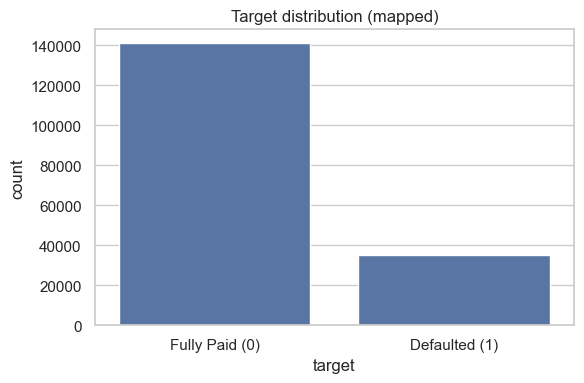

In [3]:
# Map loan_status to binary target: 0 = Fully Paid, 1 = Charged Off / Default

def map_target(x):
    if pd.isna(x):
        return np.nan
    x = str(x)
    if 'Fully Paid' in x:
        return 0
    # treat Charged Off and other default-like statuses as default
    if 'Charged Off' in x or 'Default' in x or 'Does not meet the credit policy' in x:
        return 1
    return np.nan

# Create target and show distribution

df['target'] = df['loan_status'].map(map_target)
print('Target counts (including NaN):')
display(df['target'].value_counts(dropna=False))
print('Non-null target rows:', df['target'].notna().sum())
# Filter to rows with known target for modeling/analysis
proc = df[df['target'].notna()].copy()
print('Rows with mapped target:', len(proc))

# Visualize target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=proc['target'])
plt.xticks([0,1], ['Fully Paid (0)','Defaulted (1)'])
plt.title('Target distribution (mapped)')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/target_distribution.png', dpi=150)
plt.show()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,176083.0,14619.945140,8616.185902,1000.00,8000.00,12425.00,20000.00,35000.00
int_rate,176083.0,12.109400,4.231808,5.32,8.38,11.99,14.65,28.99
annual_inc,176083.0,77496.868636,81659.554047,0.00,46000.00,65000.00,92000.00,9000000.00
dti,176081.0,18.911109,9.180814,0.00,12.31,18.34,25.09,999.00
installment,176083.0,437.107260,254.622752,14.77,251.36,376.01,581.05,1445.46


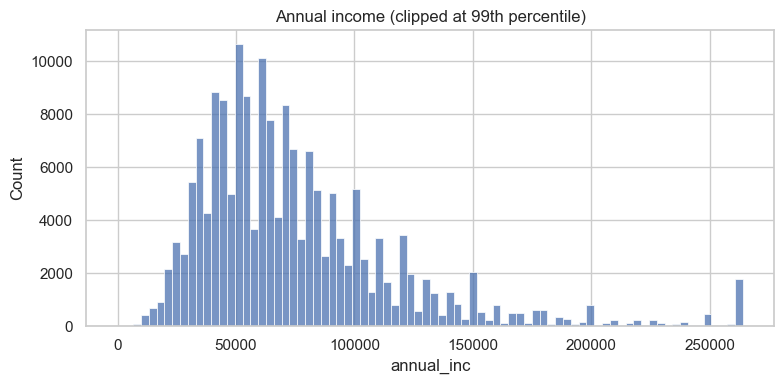

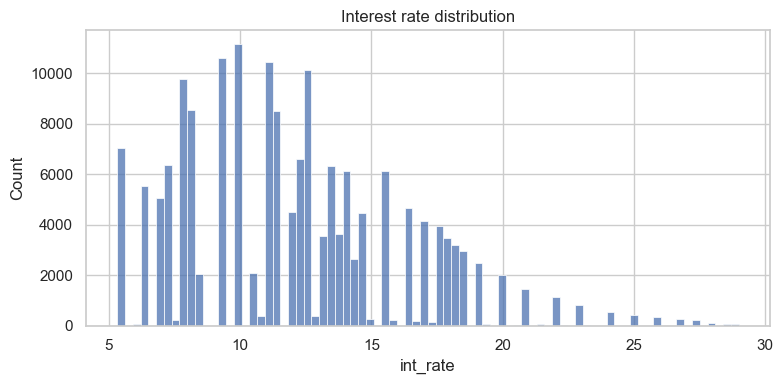

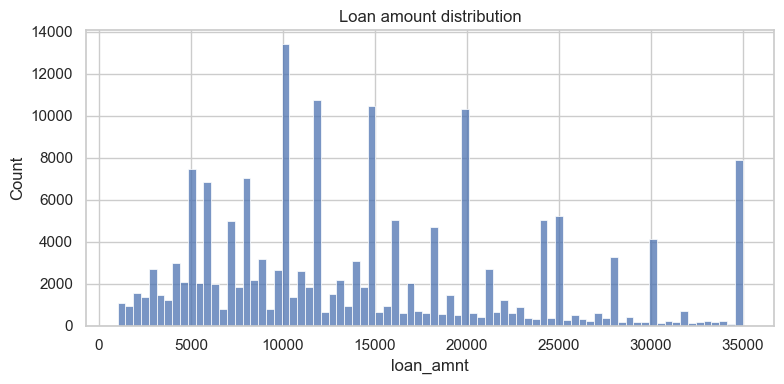

target                                        1.000000
recoveries                                    0.503149
collection_recovery_fee                       0.500366
int_rate                                      0.308953
hardship_dpd                                  0.277662
orig_projected_additional_accrued_interest    0.261282
hardship_amount                               0.241073
hardship_payoff_balance_amount                0.226919
acc_open_past_24mths                          0.135309
hardship_last_payment_amount                  0.127268
total_rec_late_fee                            0.124577
dti                                           0.114737
num_tl_op_past_12m                            0.114159
open_rv_24m                                   0.107914
open_il_24m                                   0.098433
open_il_12m                                   0.093175
total_rec_int                                 0.092212
inq_last_6mths                                0.090924
all_util  

In [4]:
# Quick numeric summaries for key columns

num_cols = ['loan_amnt','int_rate','annual_inc','dti','installment']
num_cols = [c for c in num_cols if c in proc.columns]
display(proc[num_cols].describe().T)

# Clean int_rate if stored as strings with %
if 'int_rate' in proc.columns and proc['int_rate'].dtype == 'object':
    proc['int_rate'] = proc['int_rate'].astype(str).str.rstrip('%').replace('', np.nan)
    proc['int_rate'] = pd.to_numeric(proc['int_rate'], errors='coerce')

# Plot distributions (clipping high outliers for visibility)
plt.figure(figsize=(8,4))
sns.histplot(proc['annual_inc'].dropna().clip(upper=proc['annual_inc'].quantile(0.99)), bins=80)
plt.title('Annual income (clipped at 99th percentile)')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/annual_inc_dist.png', dpi=150)
plt.show()

if 'int_rate' in proc.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(proc['int_rate'].dropna(), bins=80)
    plt.title('Interest rate distribution')
    plt.tight_layout()
    plt.savefig(f'{FIG_DIR}/int_rate_dist.png', dpi=150)
    plt.show()

if 'loan_amnt' in proc.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(proc['loan_amnt'].dropna(), bins=80)
    plt.title('Loan amount distribution')
    plt.tight_layout()
    plt.savefig(f'{FIG_DIR}/loan_amnt_dist.png', dpi=150)
    plt.show()

# Correlation with target for numeric features (point-biserial approx via Pearson)
num_for_corr = [c for c in proc.select_dtypes(include=['number']).columns if c not in ['target']]
corrs = proc[num_for_corr + ['target']].corr()['target'].sort_values(ascending=False)
display(corrs.head(20))

Plotting features: ['loan_amnt', 'int_rate', 'dti', 'installment', 'annual_inc', 'emp_length', 'delinq_2yrs', 'inq_last_6mths']


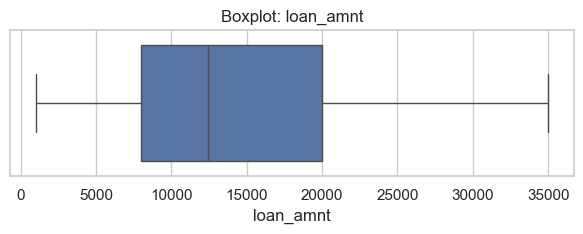

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


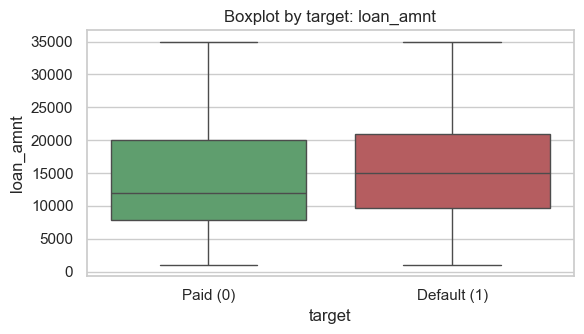

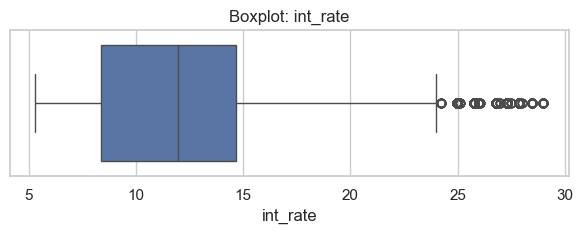

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


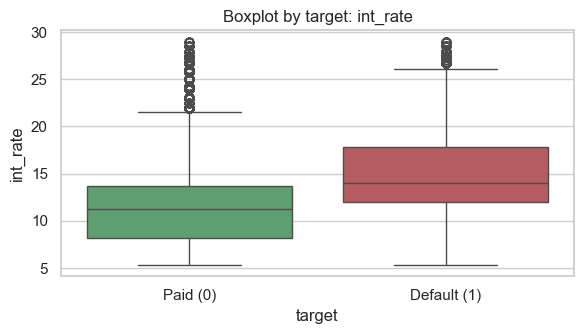

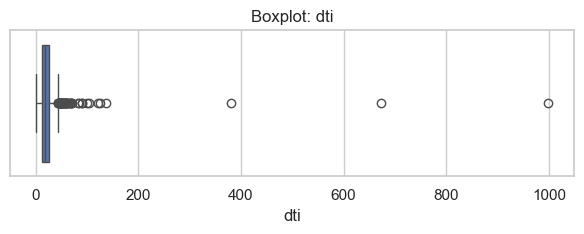

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


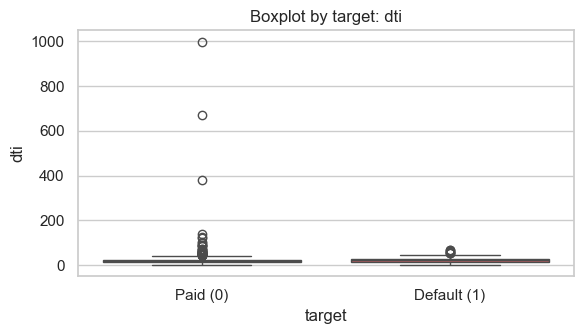

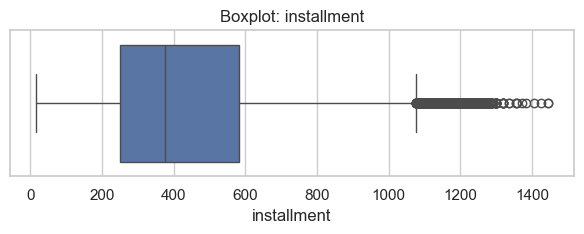

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


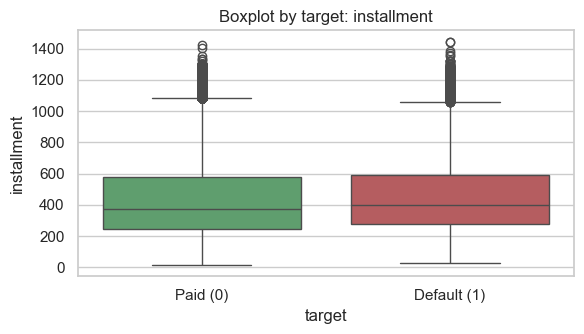

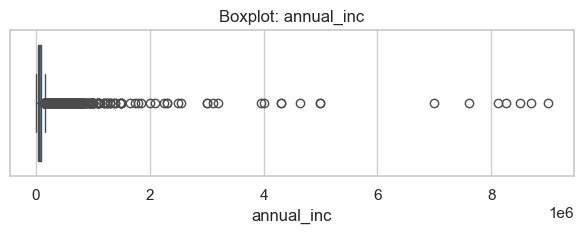

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


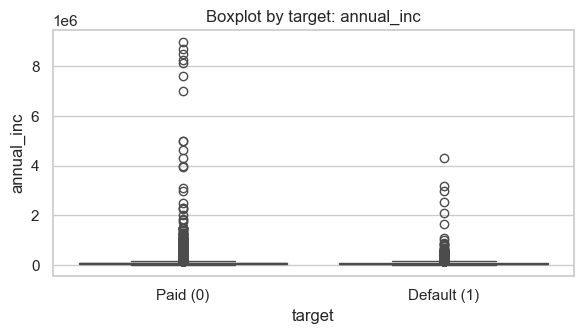

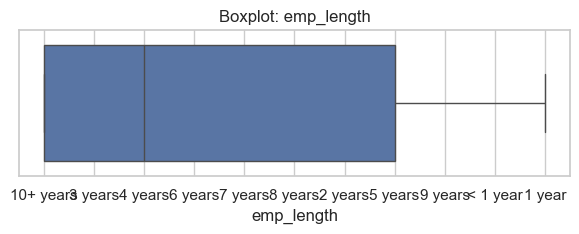

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])
/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: UserWarning: 
The palette list has fewer values (2) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


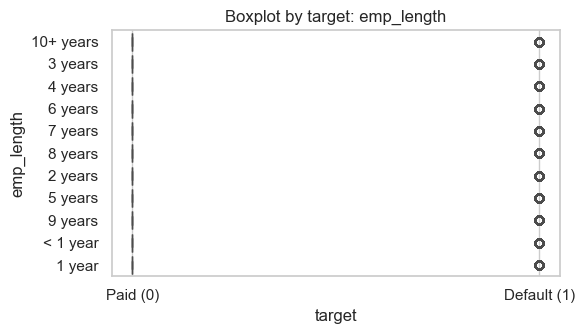

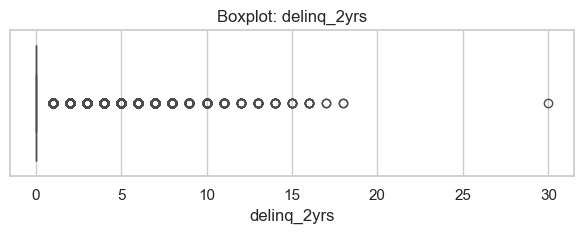

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


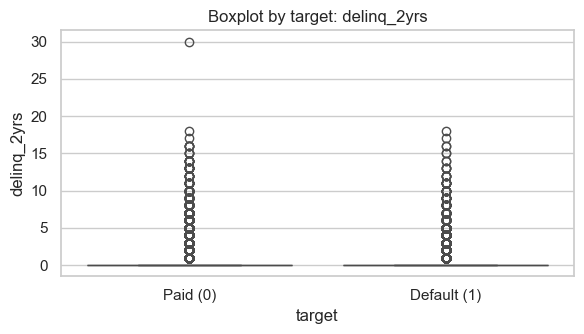

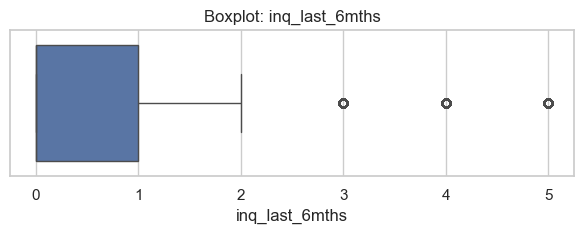

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


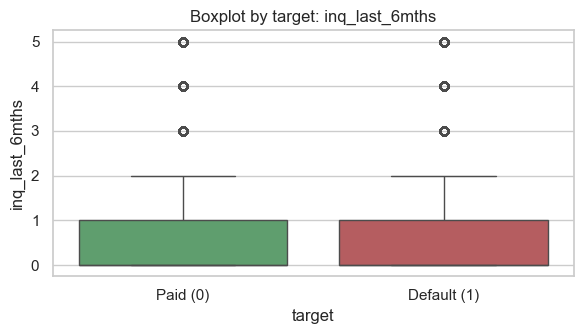

Violin plots for top features: ['int_rate', 'dti', 'inq_last_6mths']


/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


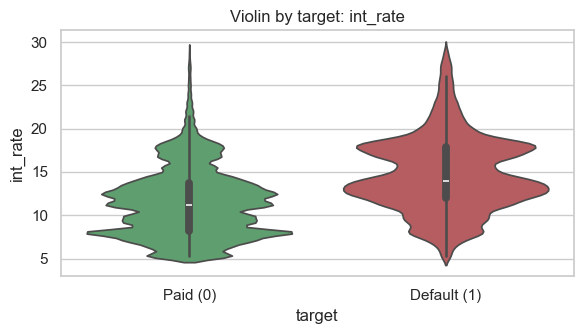

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


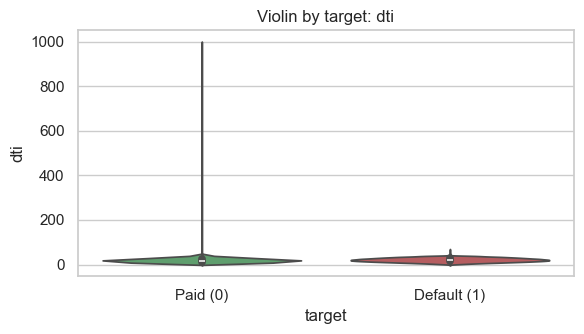

/var/folders/t3/2d2f7f6x2_9404jz_xxmbkbm0000gp/T/ipykernel_82388/1660212969.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])


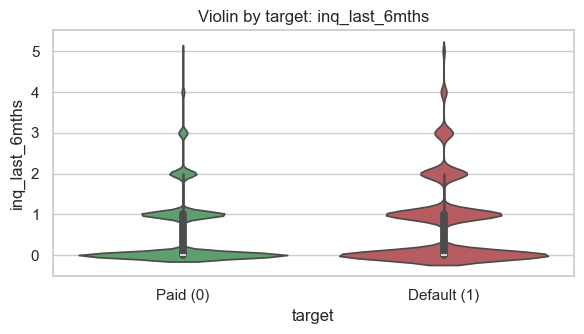

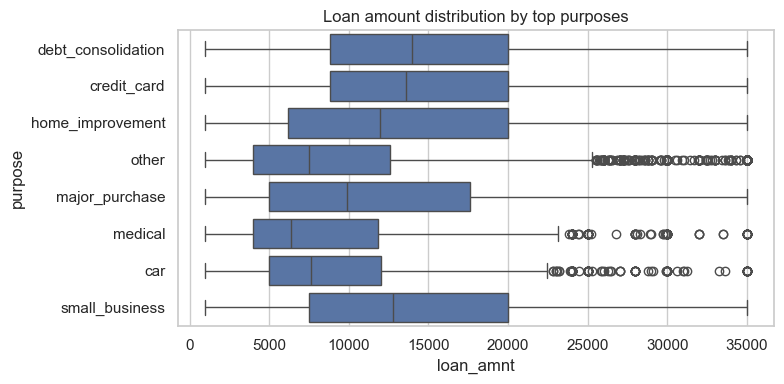

Selected boxplots/violins saved to ./figures


In [5]:
# Concise boxplots and violin plots for selected, appropriate numeric features
# Keep plots focused (no bloat): only features that are meaningful for credit risk

# Curated list (domain-informed). We'll intersect with available columns to be safe.
candidate_feats = ['loan_amnt', 'int_rate', 'dti', 'installment', 'annual_inc', 'emp_length', 'delinq_2yrs', 'inq_last_6mths']
selected_feats = [c for c in candidate_feats if c in proc.columns]
# If annual_inc exists, also add a log transform view (create temporarily for plotting)
if 'annual_inc' in selected_feats:
    proc['_log_annual_inc'] = np.log1p(proc['annual_inc'].clip(lower=0))
    selected_feats.append('_log_annual_inc')

# Limit number of plots to avoid bloat
max_feats = 8
selected_feats = selected_feats[:max_feats]
print('Plotting features:', selected_feats)

# For each selected feature, create: overall boxplot (horizontal) and boxplot split by target
for c in selected_feats:
    try:
        ser = proc[c].dropna()
        if ser.empty:
            continue
        # Horizontal boxplot for compactness
        plt.figure(figsize=(6,2.5))
        sns.boxplot(x=ser, color='C0')
        plt.title(f'Boxplot: {c}')
        plt.tight_layout()
        plt.savefig(f"{FIG_DIR}/box_{c}.png", dpi=150)
        plt.show()
        plt.close()

        # Boxplot split by target (Paid vs Default) - vertical for easier comparison
        if 'target' in proc.columns:
            plt.figure(figsize=(6,3.5))
            sns.boxplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])
            plt.xticks([0,1], ['Paid (0)','Default (1)'])
            plt.title(f'Boxplot by target: {c}')
            plt.tight_layout()
            plt.savefig(f"{FIG_DIR}/box_by_target_{c}.png", dpi=150)
            plt.show()
            plt.close()
    except Exception as e:
        print('Skipping', c, 'due to error:', e)

# Compact violin plots for top 3 numeric features by absolute correlation with target
try:
    num_for_corr = [c for c in proc.select_dtypes(include=['number']).columns if c not in ['target']]
    corrs = proc[num_for_corr + ['target']].corr()['target'].abs().sort_values(ascending=False)
    top_feats = [f for f in corrs.index.drop('target').tolist() if f in selected_feats][:3]
except Exception:
    top_feats = selected_feats[:3]

print('Violin plots for top features:', top_feats)
for c in top_feats:
    try:
        plt.figure(figsize=(6,3.5))
        sns.violinplot(x=proc['target'].astype(int), y=proc[c], palette=['C2','C3'])
        plt.xticks([0,1], ['Paid (0)','Default (1)'])
        plt.title(f'Violin by target: {c}')
        plt.tight_layout()
        plt.savefig(f"{FIG_DIR}/violin_by_target_{c}.png", dpi=150)
        plt.show()
        plt.close()
    except Exception as e:
        print('Skipping violin for', c, 'error:', e)

# One grouped boxplot: loan amount by top 8 purposes (if available) - succinct and informative
if 'purpose' in proc.columns and 'loan_amnt' in proc.columns:
    top_purp = proc['purpose'].value_counts().head(8).index.tolist()
    subset = proc[proc['purpose'].isin(top_purp)]
    plt.figure(figsize=(8,4))
    sns.boxplot(x='loan_amnt', y='purpose', data=subset, order=top_purp)
    plt.title('Loan amount distribution by top purposes')
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/loan_amnt_by_purpose.png", dpi=150)
    plt.show()
    plt.close()

print('Selected boxplots/violins saved to', FIG_DIR)



Top categories for purpose


purpose
debt_consolidation    100265
credit_card            44416
home_improvement       11241
other                   8992
major_purchase          3471
medical                 1945
car                     1534
small_business          1473
moving                  1063
vacation                 983
house                    592
renewable_energy         107
wedding                    1
Name: count, dtype: int64


Top categories for home_ownership


home_ownership
MORTGAGE    86297
RENT        69952
OWN         19833
ANY             1
Name: count, dtype: int64


Top categories for term


term
 36 months    134499
 60 months     41584
Name: count, dtype: int64


Top categories for grade


grade
B    53862
C    48665
A    34043
D    23047
E    12269
F     3422
G      775
Name: count, dtype: int64


Top categories for sub_grade


sub_grade
B3    11144
C1    11131
B4    10945
B2    10623
B1    10610
B5    10540
C2    10499
C3     9864
A5     9790
C4     9753
C5     7418
A1     7039
A4     6615
D1     6370
A2     5518
Name: count, dtype: int64

target,0.0,1.0
purpose,,
car,0.842894,0.157106
credit_card,0.834609,0.165391
debt_consolidation,0.784561,0.215439
home_improvement,0.822792,0.177208
major_purchase,0.812158,0.187842
medical,0.791260,0.208740
moving,0.775165,0.224835
other,0.798265,0.201735
small_business,0.706042,0.293958


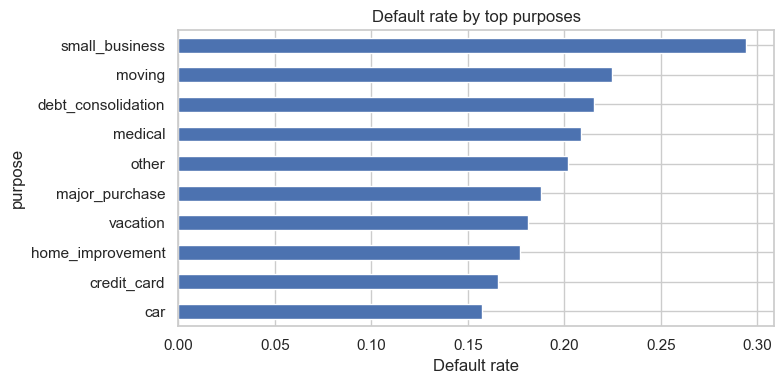

In [6]:
# Categorical summaries for a few columns
cat_cols = ['purpose','home_ownership','term','grade','sub_grade']
cat_cols = [c for c in cat_cols if c in proc.columns]
for c in cat_cols:
    print('\nTop categories for', c)
    display(proc[c].value_counts().head(15))

# Cross-tab: purpose vs target for top purposes
if 'purpose' in proc.columns:
    top_purp = proc['purpose'].value_counts().head(10).index.tolist()
    display(pd.crosstab(proc[proc['purpose'].isin(top_purp)]['purpose'], proc[proc['purpose'].isin(top_purp)]['target'], normalize='index'))
    plt.figure(figsize=(8,4))
    s = proc[proc['purpose'].isin(top_purp)].groupby('purpose')['target'].mean().sort_values()
    s.plot(kind='barh')
    plt.xlabel('Default rate')
    plt.title('Default rate by top purposes')
    plt.tight_layout()
    plt.savefig(f'{FIG_DIR}/default_rate_by_purpose.png', dpi=150)
    plt.show()

## Feature Engineering & Selection

Below I select a concise set of features for modelling and provide justification for each selection. The goal is to include features that are predictive of credit risk while keeping the representation compact for both supervised and RL approaches.

Selected features (recommended):
- `loan_amnt`: principal amount at risk (directly impacts reward/loss).
- `int_rate`: the interest rate charged — relates to risk-based pricing.
- `term`: loan term (36 vs 60 months) — longer terms often have higher default risk.
- `annual_inc`: applicant income (ability to repay).
- `dti`: debt-to-income ratio — key creditworthiness indicator.
- `emp_length`: employment duration — employment stability proxy.
- `home_ownership`: asset status (own/rent) — correlates with stability.
- `purpose`: loan purpose (debt consolidation, credit card, etc.) — default rates vary by purpose.
- `delinq_2yrs`, `inq_last_6mths`: recent derogatory history indicators.

Justification: these features capture applicant ability to pay, loan size and pricing, and short-term credit behavior. They are commonly used in credit risk models and are available in the dataset.

In [7]:
# Data cleaning and preprocessing for the selected features
!pip install -qU pyarrow
from sklearn.preprocessing import StandardScaler

# selected features (same as described above)
selected = ['loan_amnt','term','int_rate','annual_inc','dti','emp_length','home_ownership','purpose','addr_state','delinq_2yrs','inq_last_6mths']
selected = [c for c in selected if c in proc.columns]
print('Using features:', selected)
dfp = proc[selected + ['target']].copy()

# Feature engineering examples: log-transform income, cap extreme loan amounts
if 'annual_inc' in dfp.columns:
    dfp['log_annual_inc'] = np.log1p(dfp['annual_inc'].clip(lower=0))
    selected.append('log_annual_inc')
    # we keep original annual_inc for interpretability but use log version for modeling

# Clean emp_length (extract numeric years)
if 'emp_length' in dfp.columns and dfp['emp_length'].dtype == 'object':
    dfp['emp_length'] = dfp['emp_length'].astype(str).str.extract(r'(\d+)').astype(float)

# Clean term if necessary (e.g., ' 36 months')
if 'term' in dfp.columns and dfp['term'].dtype == 'object':
    dfp['term'] = dfp['term'].astype(str).str.extract(r'(\d+)').astype(float)

# Ensure numeric columns are numeric and fill with median
num_cols = dfp.select_dtypes(include=['number']).columns.tolist()
num_cols = [c for c in num_cols if c != 'target']
for c in num_cols:
    dfp[c] = pd.to_numeric(dfp[c], errors='coerce')
    med = dfp[c].median()
    dfp[c] = dfp[c].fillna(med)

# Categorical handling: fill missing and one-hot encode selected categoricals
cat_cols = [c for c in ['home_ownership','purpose','addr_state'] if c in dfp.columns]
for c in cat_cols:
    dfp[c] = dfp[c].fillna('missing').astype(str)

# One-hot encode categorical variables (drop_first to avoid collinearity)
df_final = pd.get_dummies(dfp, columns=cat_cols, drop_first=True)

# Scale numeric columns
scaler = StandardScaler()
scale_cols = [c for c in num_cols if c in df_final.columns]
df_final[scale_cols] = scaler.fit_transform(df_final[scale_cols])

# Save scaler for later use
joblib.dump(scaler, f'{DATA_DIR}/scaler.joblib')
print('Scaler saved to', f'{DATA_DIR}/scaler.joblib')

# Final feature set and shape
features_final = [c for c in df_final.columns if c != 'target']
print('Final feature count:', len(features_final))
print('Sample features:', features_final[:20])

# Persist processed sample
out_path = f'{DATA_DIR}/processed_sample.parquet'
df_final.to_parquet(out_path, index=False)
print('Saved processed sample to', out_path)

You should consider upgrading via the '/Users/charan/.pyenv/versions/3.8.11/bin/python3.8 -m pip install --upgrade pip' command.
Using features: ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'emp_length', 'home_ownership', 'purpose', 'addr_state', 'delinq_2yrs', 'inq_last_6mths']
Using features: ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'emp_length', 'home_ownership', 'purpose', 'addr_state', 'delinq_2yrs', 'inq_last_6mths']
Scaler saved to ./data/scaler.joblib
Final feature count: 72
Sample features: ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'emp_length', 'delinq_2yrs', 'inq_last_6mths', 'log_annual_inc', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other']
Scaler saved to ./data/scaler.joblib
Final feature count: 72
Sample features: ['loan_amnt', 'term', '

In [8]:
# Create train / validation / test splits and save them
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_final, test_size=0.2, random_state=42, stratify=df_final['target'])
train, val = train_test_split(train, test_size=0.1, random_state=42, stratify=train['target'])  # 10% of train => val
train.to_parquet(f'{DATA_DIR}/train.parquet', index=False)
val.to_parquet(f'{DATA_DIR}/val.parquet', index=False)
test.to_parquet(f'{DATA_DIR}/test.parquet', index=False)
print('Saved splits: train/val/test with shapes:', train.shape, val.shape, test.shape)

Saved splits: train/val/test with shapes: (126779, 73) (14087, 73) (35217, 73)


## Summary of preprocessing steps
- Mapped `loan_status` to binary `target` (0 = Fully Paid, 1 = Default/Charged Off).
- Selected a compact feature set focusing on loan terms, pricing, applicant income, and short-term credit history.
- Performed light feature engineering: log(annual_inc), numeric extraction for `term` and `emp_length`.
- Imputed numeric missing values with the column median; filled categorical NaNs with `'missing'`.
- One-hot encoded selected categorical features and standardized numeric features with `StandardScaler`.
- Saved `scaler.joblib` and processed train/val/test splits for downstream modeling.

Next: run `2_supervised.ipynb` which will load `./data/train.parquet` and train a predictive model (reporting AUC and F1). The offline-RL notebook `3_offline_rl.ipynb` will use the processed data to construct states, actions and rewards.